Note:  This notebook has widgets to select the state, congressional district and facility.  Those currently work only when the cells are run one at a time sequentially, not all at once.

## Resource Conservation and Recovery Act Enforcements by Congressional District

This notebook examines ECHO data using ECHO_EXPORTER, RCRA_FACILITIES,
and RCRA_ENFORCEMENTS.

From ECHO_EXPORTER:
<ul>
    <li>RCRA_IDS - to match facilities/violations in RCRA_FACILITIES and RCRA_VIOLATIONS</li>
    <li>FAC_DERIVED_CD113 - 113th congressional district</li>
    <li>FAC_LAT and FAC_LONG - latitude and longitude</li>
    <li>RCRA_PERMIT_TYPES</li>
</ul>

RCRA Permit Types include:
<ul>
    <li>TSDF = Treatment, Storage and Disposal facility</li>
    <li>LQG = Large Quantity Generator</li>
    <li>SQG = Small Quantity Generator</li>
    <li>CESQG = Conditionally-Exempt Small Quantity Generator</li>
</ul>

From RCRA_ENFORCEMENTS we use:
<ul>
    <li>ENFORCEMENT_DESC - a description of the enforcement action </li>
    <li>ENFORCEMENT_AGENCY - which agency executed the enforcement</li>
    <li>ENFORCEMENT_ACTION_DATE</li>
</ul>

A state and congressional district must be chosen using the dropdown
widgets that are provided.

In [1]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


Run this next cell, select a state, and then run the following cell.

In [2]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='NY',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', index=32, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

Run this next cell after choosing a state from the dropdown list.

In [3]:
my_state = dropdown_state.value

sql = "select FAC_NAME, FAC_LAT, FAC_LONG, RCRA_IDS, " + \
    "RCRA_PERMIT_TYPES, FAC_DERIVED_CD113 from ECHO_EXPORTER where RCRA_FLAG = 'Y'" + \
    "and FAC_STATE = '" + my_state + "'" 
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(sql)
print(data_location)

select FAC_NAME, FAC_LAT, FAC_LONG, RCRA_IDS, RCRA_PERMIT_TYPES, FAC_DERIVED_CD113 from ECHO_EXPORTER where RCRA_FLAG = 'Y'and FAC_STATE = 'NY'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20FAC_NAME%2C%20FAC_LAT%2C%20FAC_LONG%2C%20RCRA_IDS%2C%20RCRA_PERMIT_TYPES%2C%20FAC_DERIVED_CD113%20from%20ECHO_EXPORTER%20where%20RCRA_FLAG%20%3D%20%27Y%27and%20FAC_STATE%20%3D%20%27NY%27


In [4]:
echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)

num_facilities = echo_data.shape[0]
print("There are %s RCRA facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

There are 115135 RCRA facilities in NY tracked in the ECHO database.


Run this next cell to generate the Congressional District dropdown list for your state.  Then select a CD and run the following cell.
Here is a map of congressional districts: https://www.govtrack.us/congress/members/map

In [5]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int).unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value=1,
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…



Run this next cell after choosing a congressional district from the dropdown list.

In [6]:
my_cd = w2.value
my_cd_facs = echo_data[echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int) == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s RCRA facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 2797 RCRA facilities in NY district 1 tracked in the ECHO database.


Next look up the enforcement history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [8]:
sql = "select ID_NUMBER, ENFORCEMENT_AGENCY, ENFORCEMENT_DESC, ENFORCEMENT_ACTION_DATE " + \
        "from `RCRA_ENFORCEMENTS` where ID_NUMBER like '" + my_state + "%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
# print(data_location)
rcra_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
rcra_data.set_index( "ID_NUMBER", inplace=True)
rcra_data

,ENFORCEMENT_AGENCY,ENFORCEMENT_DESC,ENFORCEMENT_ACTION_DATE
ID_NUMBER,,,
NYD002114924,S,LETTER OF INTENT TO INITIATE ENFORCEMENT ACTION,06/06/2017
NYD980648562,E,VERBAL INFORMAL,08/12/2015
NYD002080034,S,LETTER OF INTENT TO INITIATE ENFORCEMENT ACTION,06/21/2016
NY5120010710,S,WRITTEN INFORMAL,11/08/2016
NYD980757462,S,WRITTEN INFORMAL,02/24/2017
...,...,...,...
NYD981482581,S,WRITTEN INFORMAL,07/11/2014
NYR000173872,S,WRITTEN INFORMAL,04/10/2014
NYD002063378,S,INITIAL 3008(A) COMPLIANCE,01/05/2015


In [9]:
# The RCRA_IDS can contain multiple ids for a facility. 
# The string must be parsed to get each individual id to look up in RCRA_ENFORCEMENT_HISTORY.

cd_rcra = pd.DataFrame()
no_data_ids = []
# Look through all facilities in my CD.
for fac in my_cd_facs.itertuples():
    # print( type( fac ))
    # breakpoint()
    ids = fac.RCRA_IDS
    # Look at each RCRA_ID belonging to the facility
    for rcra_id in ids.split():
        try:
            # Find the rcra_id in the RCRA_VIOLATION_HISTORY, if any exist there.
            # It can match a ID_NUMBER, which is the index of rcra_data.
            rcra_fac = rcra_data.loc[ rcra_id ].copy()
            # Add the facility's index number to rcra_fac, to refer to it.
            n = rcra_fac.shape[0]
            fac_list = [fac.Index] * n
            rcra_fac['facility'] = fac_list
            # Make a frame that contains the violations.  Add it to my_cd_icis.
            frames = [cd_rcra, rcra_fac]
            cd_rcra = pd.concat( frames, ignore_index=False )
        except KeyError:
            # The air_id wasn't found in RCRA_VIOLATION_HISTORY.
            no_data_ids.append( rcra_id )

cd_rcra

# my_cd_icis.to_csv( r'my_cd_icis.csv', index=True, header=True )
# with open( "no_data_ids.txt", "w" ) as output:
#     output.write( str( no_data_ids ))

,0,ENFORCEMENT_ACTION_DATE,ENFORCEMENT_AGENCY,ENFORCEMENT_DESC,facility
ENFORCEMENT_AGENCY,S,NaN,NaN,NaN,NaN
ENFORCEMENT_DESC,WRITTEN INFORMAL,NaN,NaN,NaN,NaN
ENFORCEMENT_ACTION_DATE,10/14/1999,NaN,NaN,NaN,NaN
facility,"[64, 64, 64]",NaN,NaN,NaN,NaN
ENFORCEMENT_AGENCY,S,NaN,NaN,NaN,NaN
...,...,...,...,...,...
facility,"[115035, 115035, 115035]",NaN,NaN,NaN,NaN
ENFORCEMENT_AGENCY,E,NaN,NaN,NaN,NaN
ENFORCEMENT_DESC,WRITTEN INFORMAL,NaN,NaN,NaN,NaN
ENFORCEMENT_ACTION_DATE,09/09/1999,NaN,NaN,NaN,NaN


Map the facilities that have had these serious CAA violations.

In [10]:
fac_idx_list = cd_rcra['facility'].dropna()
fac_cd_rcra = my_cd_facs.loc[fac_idx_list]
fac_cd_rcra

,FAC_NAME,FAC_LAT,FAC_LONG,RCRA_IDS,RCRA_PERMIT_TYPES,FAC_DERIVED_CD113
357.0,THOMPSON AIRCRAFT TIRES,40.809490,-73.234550,NYD174569657,Other,1.0
357.0,THOMPSON AIRCRAFT TIRES,40.809490,-73.234550,NYD174569657,Other,1.0
457.0,VOJVODA CLEANERS,40.921360,-72.653650,NYD101204246,VSQG,1.0
457.0,VOJVODA CLEANERS,40.921360,-72.653650,NYD101204246,VSQG,1.0
457.0,VOJVODA CLEANERS,40.921360,-72.653650,NYD101204246,VSQG,1.0
...,...,...,...,...,...,...
114904.0,STONY BROOK UNIVERSITY,40.920898,-73.133462,NYD040464315 NYR000104570,"LQG, Other",1.0
114904.0,STONY BROOK UNIVERSITY,40.920898,-73.133462,NYD040464315 NYR000104570,"LQG, Other",1.0
114904.0,STONY BROOK UNIVERSITY,40.920898,-73.133462,NYD040464315 NYR000104570,"LQG, Other",1.0
114904.0,STONY BROOK UNIVERSITY,40.920898,-73.133462,NYD040464315 NYR000104570,"LQG, Other",1.0


In [11]:
# Let's show a quick map of your area and the facilities in it

def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]],
        zoom_start = 11
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        folium.Marker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"] ).add_to(m)

    # Show the map
    return m

map_of_facilities_in_cd = mapper(fac_cd_rcra)
map_of_facilities_in_cd

Present another dropdown with the list of names of the facilities.  Choosing a facility will display
the violations.

In [12]:
cd_array = fac_cd_rcra["FAC_NAME"].unique()
cd_array.sort()

w3=widgets.Dropdown(
    options=cd_array,
    description='Facility Name:',
    disabled=False,
)
display(w3)

Dropdown(description='Facility Name:', options=('106TH RESCUE WING, NEW YORK AIR NATIONAL GUARD', 'A B M OILS'…

Run this next cell after choosing a facility.

RCRA Permit Types:
<ul>
    <li>TSDF = Treatment, Storage and Disposal facility</li>
    <li>LQG = Large Quantity Generator</li>
    <li>SQG = Small Quantity Generator</li>
    <li>CESQG = Conditionally-Exempt Small Quantity Generator</li>
</ul>

In [13]:
my_fac = fac_cd_rcra[fac_cd_rcra["FAC_NAME"] == w3.value]
violations = cd_rcra[cd_rcra['facility'] == my_fac.iloc[[0]].index[0]]
print( my_fac.iloc[0] )
violations


FAC_NAME             CORNELL UNIVERSITY LONG ISLAND HORTICULTURAL R...
FAC_LAT                                                        40.9633
FAC_LONG                                                      -72.7144
RCRA_IDS                                                  NY0000074799
RCRA_PERMIT_TYPES                                                 VSQG
FAC_DERIVED_CD113                                                    1
Name: 39715.0, dtype: object


,0,ENFORCEMENT_ACTION_DATE,ENFORCEMENT_AGENCY,ENFORCEMENT_DESC,facility
NY0000074799,NaN,11/12/1998,S,FINAL 3008(A) COMPLIANCE ORDER,39715.0
NY0000074799,NaN,06/30/1998,S,INITIAL 3008(A) COMPLIANCE,39715.0


In [14]:
# This cell creates a function that will be used by both the CD and the state
# to plot the number of cases by year.
import datetime

def show_plot( df, date_field, year_field, place, date_format, chart_title ):
    format_str = date_format # The format
    nan_count = 0
    year_col = []
    for day in df[date_field]:
        try:
            # breakpoint()
            viol_year = datetime.datetime.strptime(day, format_str).year
            year_col.append( viol_year )
        except:
            nan_count += 1
            year_col.append(  np.NaN )
    df[year_field] = year_col
    
    year_groups = df.groupby( year_field )[[ year_field ]]
    counted_years = year_groups.count()

    # Print how many values are present 
    print(counted_years)
    chart_title +=  " in " + place + " by year"

    ax = counted_years[[year_field]].plot(kind='bar', title = chart_title, figsize=(15, 10), legend=False, fontsize=12)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

## Plot the number of enforcements by year for the congressional district.

                  YEAR_ENFORCEMENT
YEAR_ENFORCEMENT                  
1983.0                           3
1984.0                           4
1985.0                          15
1986.0                           8
1987.0                          22
1988.0                          17
1989.0                           7
1990.0                          11
1991.0                           6
1992.0                           7
1993.0                          17
1994.0                          24
1995.0                          11
1996.0                           7
1997.0                          10
1998.0                          20
1999.0                          31
2000.0                          14
2001.0                           9
2002.0                           9
2003.0                          10
2004.0                          16
2005.0                          10
2006.0                          13
2007.0                          15
2008.0                          22
2009.0              

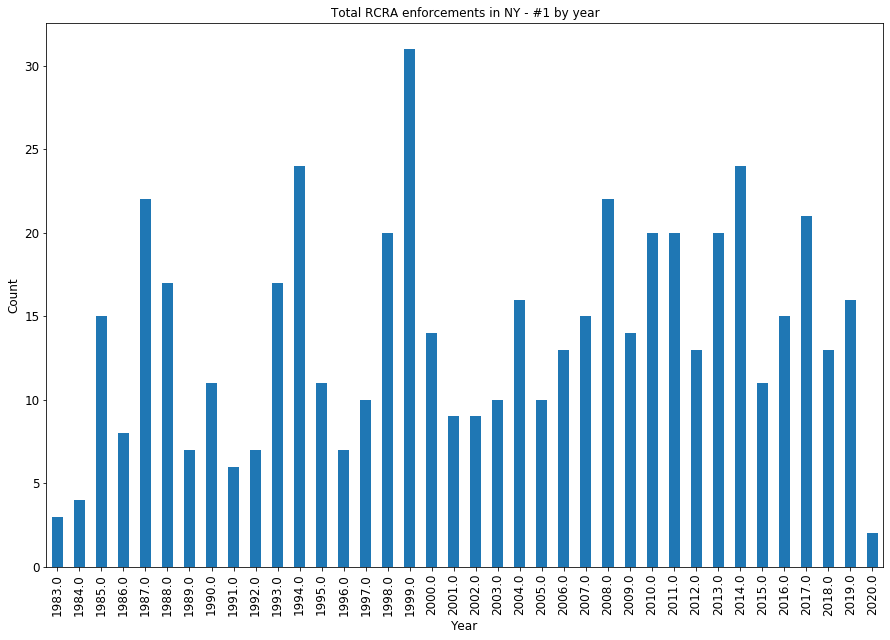

In [15]:
chart_title = "Total RCRA enforcements"

show_plot( cd_rcra, 'ENFORCEMENT_ACTION_DATE', 'YEAR_ENFORCEMENT', \
          my_state + ' - #' + str( my_cd ), '%m/%d/%Y', chart_title )

## Plot the number of enforcements by year, using the entire state.
Since the number of enforcements in a single CD may be small, it can be more
interesting to look at the entire state.

                  YEAR_ENFORCEMENT
YEAR_ENFORCEMENT                  
1981                             1
1982                            14
1983                            82
1984                           289
1985                           450
1986                           588
1987                           653
1988                           615
1989                           483
1990                           505
1991                           512
1992                           342
1993                           577
1994                           616
1995                           290
1996                           404
1997                           464
1998                           394
1999                           456
2000                           494
2001                           419
2002                           447
2003                           492
2004                           429
2005                           400
2006                           425
2007                

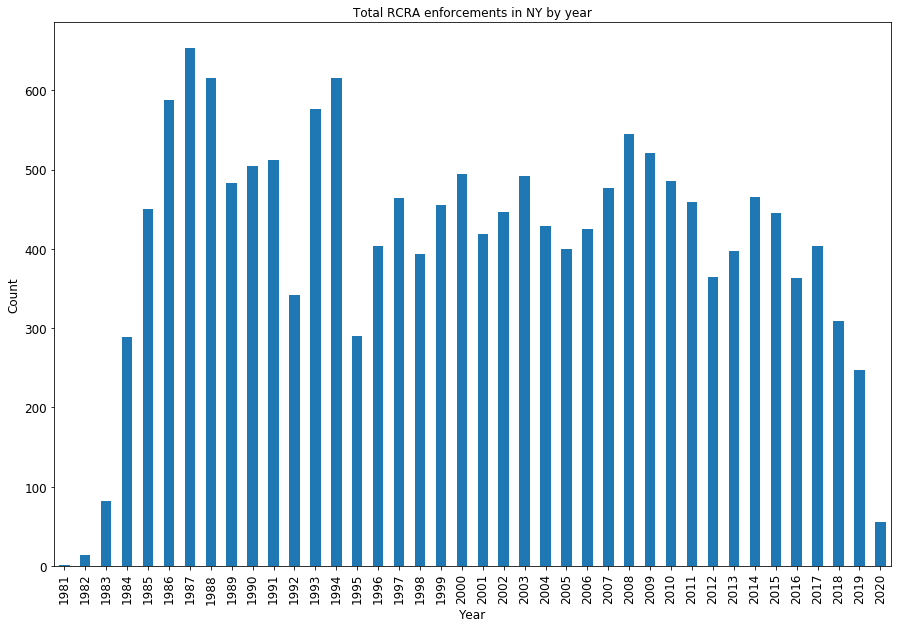

In [16]:
chart_title = "Total RCRA enforcements"

show_plot( rcra_data, 'ENFORCEMENT_ACTION_DATE', 'YEAR_ENFORCEMENT', \
          my_state, '%m/%d/%Y', chart_title )